In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
sys.path.append('/home/manu/TFG_repo/scripts')  # make modules in scripts folder callable from notebooks

In [14]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from utide import solve
plt.style.use('/home/manu/TFG_repo/notebooks/notebook.mplstyle')

In [15]:
from analysis_functions import *

In [27]:
temp, pres, date, lat, lon = load_time_series('AGL_1_SB56.h5')

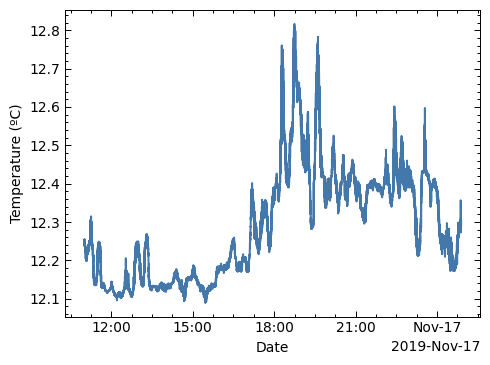

In [5]:
plot_single_thermistor(temp, pres, date, 8, lims=[0, 10000])

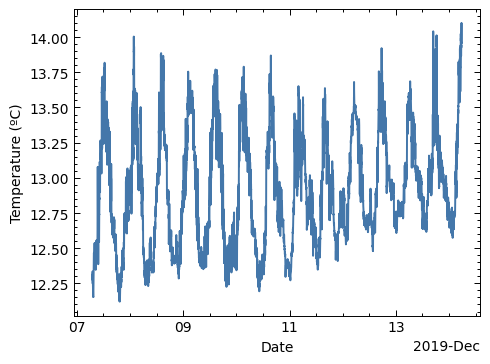

In [55]:
plot_single_thermistor(temp, pres, date, 9, lims=[30000, 40000])

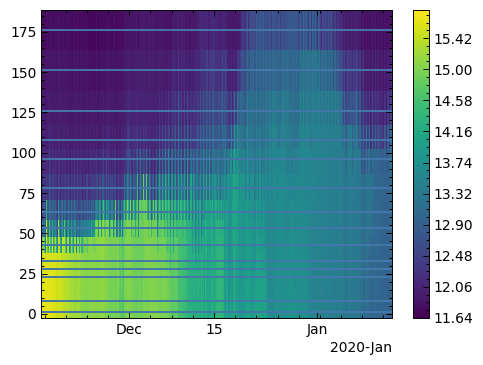

In [14]:
plot_column_temperature(temp, pres, date, lims=[0, 1000000], interval=1)

### U-Tide

In [28]:
# trim time series
dn = 12 # get datapoints every 60 seconds, not every 5
n_max = int(timedelta(days=30).total_seconds()/5)
date = date[:n_max:dn]
temp = temp[:, :n_max:dn]

[datetime.datetime(2019, 11, 16, 11, 0)
 datetime.datetime(2019, 11, 16, 11, 1)
 datetime.datetime(2019, 11, 16, 11, 2) ...
 datetime.datetime(2019, 12, 16, 10, 56, 59)
 datetime.datetime(2019, 12, 16, 10, 57, 59)
 datetime.datetime(2019, 12, 16, 10, 58, 59)]


In [29]:
coef = solve(date, temp[8], lat=lat)

solve: matrix prep ... solution ... done.


In [30]:
print(coef.keys())

dict_keys(['name', 'aux', 'nR', 'nNR', 'nI', 'weights', 'A', 'g', 'mean', 'slope', 'g_ci', 'A_ci', 'diagn', 'PE', 'SNR'])


In [47]:
help(solve)

Help on function solve in module utide._solve:

solve(t, u, v=None, lat=None, **opts)
    Calculate amplitude, phase, confidence intervals of tidal constituents.
    
    Parameters
    ----------
    t : array_like
        Time in days since `epoch`, or np.datetime64 array, or pandas datetime array.
    u : array_like
        Sea-surface height, velocity component, etc.
    v : {None, array_like}, optional
        If `u` is a velocity component, `v` is the orthogonal component.
    lat : float, required
        Latitude in degrees.
    epoch : {string, `datetime.date`, `datetime.datetime`}, if datenum is provided in t.
        Default `None` if `t` is `datetime`, `np.datetime64`, or `pd.datetime array.`
        Optional valid strings are
            - 'python' : if `t` is days since '0000-12-31'
            - 'matlab' : if `t` is days since '0000-00-00'
        Or, an arbitrary date in the form 'YYYY-MM-DD'.
    constit : {'auto', sequence}, optional
        List of strings with stand

### FFT

In [91]:
temp, pres, date, lat, lon = load_time_series('AGL_1_SB56.h5')

In [92]:
from scipy.fft import fft, fftfreq, ifft

def spectrum(x, dt):
    n = len(x)
    pslice = slice(1, n//2)
    freqs = fftfreq(n, d=dt)[pslice]
    amplitude = fft(x)[pslice]
    
    power = 2 * np.abs(amplitude)**2 / n**2
    psd = power * dt * n # power spectral density
    
    return freqs, power, psd

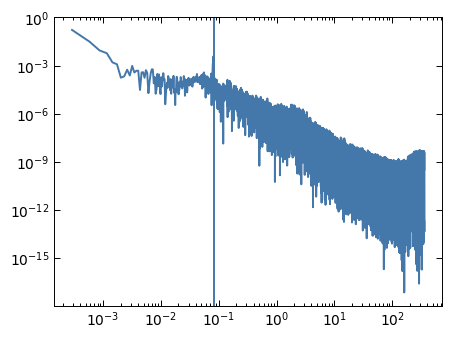

In [100]:
dt = 5 # seconds
dt = 5/60/60 # hours
tidal_frecuency = 1/12
freqs, power, psd = spectrum(temp[8], dt=dt)
fig, ax = plt.subplots()
ax.loglog(freqs, power)
ax.axvline(tidal_frecuency)
plt.show()